<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/main/Demos/Misc_speedExamples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speed considerations in Python
In Matlab, most students know the cardinal rule of "avoid `for` loops. In Python, this is still true, but there are more alternatives, and if you use the wrong alternative, the code may still be slow. The basic Python constructions are good for maintaining and debugging code, but not necessarily for speed. The rule-of-thumb is that if there is a `numpy` version that does the same thing as the basic Python version, then the `numpy` version is faster.

## An example: finding the maximum of an array

In [2]:
import numpy as np
from numpy.linalg import norm
from timeit import timeit
from jax import vmap, jit
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from matplotlib import pyplot as plt

n = int(1e7)
x = np.random.randn(n)
xList = x.tolist()

type(x), type(xList)

(numpy.ndarray, list)

Run using a mixture of pure python (`max` and `abs`) and `numpy` (the datatype of `x` is `numpy.ndarray`)

In [3]:
%time mx = max(abs(x))

CPU times: user 1.44 s, sys: 30.7 ms, total: 1.47 s
Wall time: 2.49 s


Run using pure Python, via a list comprehension, essentially just a `for` loop

In [4]:
%time mx = max(abs(xx) for xx in xList)

CPU times: user 657 ms, sys: 1.94 ms, total: 659 ms
Wall time: 703 ms


Run using pure `numpy`

In [5]:
%time mx = np.max(np.abs(x))

CPU times: user 17.3 ms, sys: 15.8 ms, total: 33.1 ms
Wall time: 32.9 ms


another way in `numpy`

In [6]:
%time mx = norm(x,ord=np.inf)

CPU times: user 18.3 ms, sys: 14.8 ms, total: 33.1 ms
Wall time: 32.6 ms


## Another example of timing
We have a piecewise defined function, so in its definition there is an `if` statement.

When possible, it's nice to avoid these `if` statements --- this helps the compiler with [branch prediction](https://en.wikipedia.org/wiki/Branch_predictor), see, e.g., this Medium article on [Branchless programming — Why your CPU will thank you](https://sdremthix.medium.com/branchless-programming-why-your-cpu-will-thank-you-5f405d97b0c8)

You can use [`numpy.vectorize`](https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html) but it won't help too much, because as the documentation says, "The vectorize function is provided primarily for convenience, not for performance. The implementation is essentially a for loop."

Jax's [vmap](https://docs.jax.dev/en/latest/_autosummary/jax.vmap.html) is a smarter version of `numpy.vectorize` and **is** designed to give performance boosts. Sometimes it might be more clever than you vectorizing yourself, sometimes less clever.

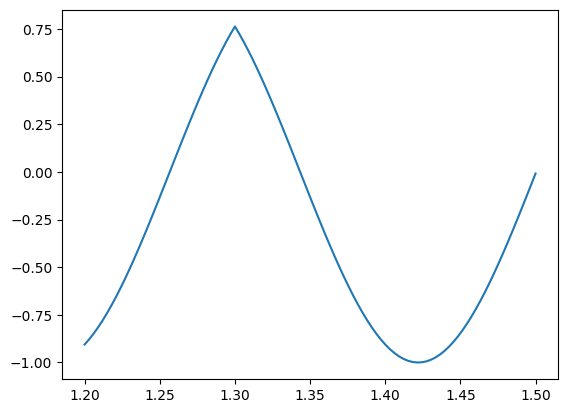

In [7]:
f = lambda x : np.sin(20*x)
n = 1e7
x = np.linspace(1,2,int(n))

# The function we want, defined for a scalar input
def g(x):
    if x < 1.3:
        return f(x)
    else:
        return f(2.6-x)

@np.vectorize # This tells Python to apply np.vectorize to the following function (a "decorator")
def g_slow(x):
    if x < 1.3:
        return f(x)
    else:
        return f(2.6-x)

# or...
g_slow = np.vectorize(g)

xGrid = np.linspace(1.2,1.5,100)
plt.plot(xGrid,g_slow(xGrid))
plt.show()

In [8]:
%time out = g_slow(x)

CPU times: user 12.9 s, sys: 499 ms, total: 13.4 s
Wall time: 13.5 s


In [9]:
def g_for_loop():
    output = np.empty(int(n))
    for i, xx in enumerate(x):
        output[i] = g_slow(xx)
    return output
# Another way, likely even slower:
# def g_for_loop():
#     output = []
#     for xx in x:
#         output.append(g_slow(xx))
#     return np.array(output)

%time out2 = g_for_loop()
print(f'Discrepancy is {np.linalg.norm(out-out2)}') # make sure we get the same answer

CPU times: user 1min 58s, sys: 101 ms, total: 1min 58s
Wall time: 2min
Discrepancy is 0.0


In [10]:
def g_list_comprehension():
    return [g_slow(xx) for xx in x]
    # or
    # return np.array([g_slow(xx) for xx in x])

%time out2 = g_list_comprehension()
print(f'Discrepancy is {np.linalg.norm(out-out2)}') # make sure we get the same answer

CPU times: user 1min 53s, sys: 997 ms, total: 1min 54s
Wall time: 1min 54s
Discrepancy is 0.0


In [11]:
g_piecewise = lambda x : np.piecewise( x, x<1.3, [f, lambda x : f(2.6-x)] )
%time out2 = g_piecewise(x)
print(f'Discrepancy is {np.linalg.norm(out-out2)}') # make sure we get the same answer

CPU times: user 7.57 s, sys: 254 ms, total: 7.82 s
Wall time: 8.75 s
Discrepancy is 0.0


In [20]:
g_bitwise = lambda x : (x<1.3)*f(x) + (x>=1.3)*f(2.6-x)
# we can use %time or %timeit. The latter takes an average and reports a standard deviation
#   If we expect the code to be fast, it's nice to use %timeit
%timeit out2 = g_bitwise(x)
print(f'Discrepancy is {np.linalg.norm(out-out2)}') # make sure we get the same answer

615 ms ± 140 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Discrepancy is 0.0


In [21]:
g_where = lambda x : np.where( x < 1.3, f(x), f(2.6-x))
%timeit out2 = g_where(x)
print(f'Discrepancy is {np.linalg.norm(out-out2)}') # make sure we get the same answer

526 ms ± 92.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Discrepancy is 0.0


and first attempt to use JAX:

In [13]:
g_vmap = vmap(g)

# JAX doesn't like this! It cannot handle the logic as we implemented it
out2 = g_vmap(jnp.array(x))

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
This BatchTracer with object id 138162841971376 was created on line:
  /tmp/ipython-input-571379421.py:7:7 (g)
See https://docs.jax.dev/en/latest/errors.html#jax.errors.TracerBoolConversionError

Correctly using JAX:

In [14]:
f_jax = lambda x : jnp.sin(20*x)
f_jax_reflected = lambda x : f_jax(2.6-x)
def g_piecewise(x):
    return jax.lax.cond( x<1.3, f_jax, f_jax_reflected, x)

# Adding jax.jit doesn't help for small inputs
g_vmap = vmap(g_piecewise)

%time out2 = g_vmap(jnp.array(x))
print(f'Discrepancy is {np.linalg.norm(out-out2)}') # make sure we get the same answer

CPU times: user 513 ms, sys: 224 ms, total: 737 ms
Wall time: 427 ms
Discrepancy is 0.0


In [17]:
# Adding jax.jit helps if the input is large enough...
g_vmap = jit(vmap(g_piecewise))

%timeit out2 = g_vmap(jnp.array(x))
print(f'Discrepancy is {np.linalg.norm(out-out2)}') # make sure we get the same answer

75.1 ms ± 25.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Discrepancy is 0.0


In [18]:
g_vmap = vmap(jit(g_piecewise)) # changing the order of vmap and jit

%timeit out2 = g_vmap(jnp.array(x))
print(f'Discrepancy is {np.linalg.norm(out-out2)}') # make sure we get the same answer

459 ms ± 105 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Discrepancy is 0.0
